# Image pipeline

In [1]:
# Utility functions
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
from skimage.feature import hog


convertors = {
    'RGB': cv2.COLOR_BGR2RGB,
    'HLS': cv2.COLOR_BGR2HLS,
    'YUV': cv2.COLOR_BGR2YUV,
    'YCrCb': cv2.COLOR_BGR2YCrCb,
    'Lab': cv2.COLOR_BGR2Lab,
    'Luv': cv2.COLOR_BGR2Luv,
}

# feature extraction functions

def color_hist(img, nbins=128, bins_range=(0, 256)):
    channel1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    features = np.concatenate((channel1[0], channel2[0], channel3[0]))
    return features

def bin_spatial(img, size=(16, 16)):
    resize_img = cv2.resize(img, size)
    color1 = resize_img[:,:,0].ravel()
    color2 = resize_img[:,:,1].ravel()
    color3 = resize_img[:,:,2].ravel()
    features = np.hstack((color1, color2, color3))
    return features

def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, feature_vec=False):
    return hog(
        img, orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block),
        visualise=False, feature_vector=feature_vec)

# sliding window search

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    for bbox in bboxes:
        top_left = bbox[0]
        bottom_right = bbox[1]
        cv2.rectangle(imcopy, (top_left[0], top_left[1]), (bottom_right[0], bottom_right[1]), color, thick)
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    window_list = []
    x_start = x_start_stop[0] if x_start_stop[0] else 0
    y_start = y_start_stop[0] if y_start_stop[0] else 0
    x_stop = x_start_stop[1] if x_start_stop[1] else img.shape[0]
    y_stop = y_start_stop[1] if y_start_stop[1] else img.shape[1]
    window_w = xy_window[0]
    window_h = xy_window[1]
    
    x_step = np.int(window_w * xy_overlap[0])
    y_step = np.int(window_h * xy_overlap[1])
    x_stop = x_stop - window_w
    y_stop = y_stop - window_h
    
    for top in range(y_start, y_stop+1, y_step):
        for left in range(x_start, x_stop+1, x_step):
            top_left = (top, left)
            bottom_right = (top + window_w, left + window_h)
            window_list.append((top_left, bottom_right))
            
    return window_list


In [3]:
# load params and classifier from pickled file
scv = None
X_scaler = None
orient = None
pix_per_cell = None
cell_per_block = None
spatial_size = None
hist_bins = None
color_space = None

with open('./svc_pickle.p', 'rb') as f:
    data_pickle = pickle.load(f)
    scv = data_pickle['scv'] 
    X_scaler = data_pickle['scaler'] 
    orient = data_pickle['orient'] 
    pix_per_cell = data_pickle['pix_per_cell'] 
    cell_per_block = data_pickle['cell_per_block'] 
    spatial_size = data_pickle['spatial_size'] 
    hist_bins = data_pickle['hist_bins'] 
    color_space = data_pickle['color_space'] 


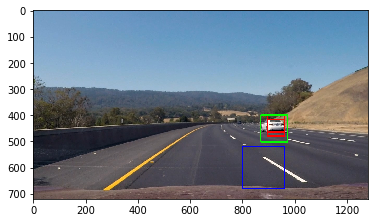

In [36]:
# Define a single function that can extract features using hog sub-sampling and make predictions

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, color_spcae):
    
    car_windows = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, convertors[color_space])
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            hist_features = color_hist(subimg, nbins=hist_bins)
            spatial_features = bin_spatial(subimg, size=spatial_size)
            
            # Scale features and make a prediction
            all_features = np.hstack((hist_features, spatial_features, hog_features)).reshape(1, -1)
            
            test_features = X_scaler.transform(all_features)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
             
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows
    

# load params and classifier from pickled file
svc = None
X_scaler = None
orient = None
pix_per_cell = None
cell_per_block = None
spatial_size = None
hist_bins = None
color_space = None

with open('./svc_pickle.p', 'rb') as f:
    data_pickle = pickle.load(f)
    svc = data_pickle['svc'] 
    X_scaler = data_pickle['scaler'] 
    orient = data_pickle['orient'] 
    pix_per_cell = data_pickle['pix_per_cell'] 
    cell_per_block = data_pickle['cell_per_block'] 
    spatial_size = data_pickle['spatial_size'] 
    hist_bins = data_pickle['hist_bins'] 
    color_space = data_pickle['color_space'] 


# ystart, ystop, scale
searches = [
    (400, 656, 1.0, (0, 0, 255)),
    (400, 700, 1.6, (0, 255, 0)),
    (400, 720, 2.5, (255, 0, 0)),
]
bbox_list = []

filename = './test_images/test3.jpg'
img = cv2.imread(filename)
draw_img = np.copy(img)
for ystart, ystop, scale, color in searches:
    bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, color_space)
    if len(bboxes) > 0:
        bbox_list.append(bboxes)
    draw_img = draw_boxes(draw_img, bboxes, color=color, thick=3)

plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
plt.show()

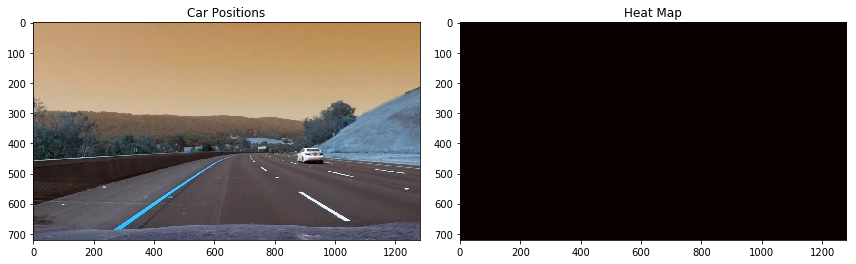

In [37]:
# Draw heatmap
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap


def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat, np.concatenate(bbox_list))

# Apply threshold to help remove false positives
heat = apply_threshold(heat,8)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()